In [1]:
# from sklearn import set_config

# set_config(transform_output="pandas")

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [3]:
# reading
url = "https://drive.google.com/file/d/1EExL9PIDVZpHVH7fnXU5mtQMt8GUtpyC/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# X and y creation
X = data.drop(columns=["Id", "Alley", "PoolQC", "Fence", "MiscFeature", "LotFrontage", "SaleType", "SaleCondition", "YrSold", "MoSold"])
y = X.pop("SalePrice")

In [6]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
X_cat_col = X.select_dtypes(exclude="number").copy().columns
X_num_col = X.select_dtypes(include="number").copy().columns

In [8]:
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

In [9]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
    MinMaxScaler())

In [10]:
# categoric_pipe = make_pipeline(
#     SimpleImputer(strategy="constant", fill_value="N_A"),
#     OneHotEncoder(handle_unknown="ignore",sparse_output=False)
# )

In [11]:
# which columns do we want to ordinal encode? (we need the index)
columns_to_ordinal = X_cat_col.get_indexer(['ExterQual', 'ExterCond', 
                                                'BsmtQual', 'BsmtCond',
                                                'BsmtExposure', 'BsmtFinType1', 
                                                'KitchenQual', 'FireplaceQu'])

# Then we need a list of lists for all columns that we want to ordinal encode and the order of their values
ExterQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]

cats_ord = [ExterQual_cats, ExterCond_cats, BsmtQual_cats, BsmtCond_cats, 
            BsmtExposure_cats, BsmtFinType1_cats, KitchenQual_cats, FireplaceQu_cats]

In [12]:
# initialize the ordinal_encoder
ordinal_encoder = OrdinalEncoder(categories=cats_ord)

# the remaining columns go to OneHot
columns_to_ohe = X_cat_col.get_indexer(list(set(X_cat) - set(columns_to_ordinal)))

# initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown="ignore")

In [13]:
# Now start from the bottom to build the preprocessor
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", ordinal_encoder, columns_to_ordinal),
        ("cat_onehot", ohe_encoder, columns_to_ohe),
    ]
)


categoric_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder)

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_col),
        ("cat_pipe", categoric_pipe, X_cat_col),
    ]
)

## Baseline Method with DecisionTreeRegressor

In [15]:
pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('model', DecisionTreeRegressor())])

In [16]:
# Make predictions
y_train_pred_tree = pipeline_tree.predict(X_train)
y_test_pred_tree = pipeline_tree.predict(X_test)

# Evaluate the model using RMSE
train_rmse_tree = mean_squared_error(y_true=y_train, y_pred=y_train_pred_tree, squared=False)
test_rmse_tree = mean_squared_error(y_test, y_test_pred_tree, squared=False)

train_rmse_tree = mean_squared_error(y_true=y_train, y_pred=y_train_pred_tree, squared=False)
test_rmse_tree = mean_squared_error(y_test, y_test_pred_tree, squared=False)

# print(f"Improved Model Train RMSE: {train_rmse_tree:.2f}")
# print(f"Improved Model Test RMSE: {test_rmse_tree:.2f}")

In [17]:
pipeline_KN = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=1))
])

pipeline_KN.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('model', KNeighborsRegressor(n_neighbors=1))])

In [18]:
# Make predictions
y_train_pred_KN = pipeline_KN.predict(X_train)
y_test_pred_KN = pipeline_KN.predict(X_test)

# Evaluate the model using RMSE
train_rmse_KN = mean_squared_error(y_true=y_train, y_pred=y_train_pred_KN, squared=False)
test_rmse_KN = mean_squared_error(y_test, y_test_pred_KN, squared=False)

# print(f"Improved Model Train RMSE: {train_rmse_KN:.2f}")
# print(f"Improved Model Test RMSE: {test_rmse_KN:.2f}")

In [19]:
performances = pd.DataFrame(columns=["performance_tree", "performance_knn"])

In [20]:
# Add the first performances of the baseline models to the DataFrame.
performances.loc["baseline", "performance_tree"] = mean_squared_log_error(y_test, y_test_pred_tree)
performances.loc["baseline", "performance_knn"] = mean_squared_log_error(y_test, y_test_pred_KN)

performances

,performance_tree,performance_knn
baseline,0.036514,0.051006


## Variance Threshold

In [21]:
# Use .describe() to get the min and max values for each feature.
# Transpose for better legibility.
X.describe().loc[["min", "max"]].T

,min,max
MSSubClass,20.0,190.0
LotArea,1300.0,215245.0
OverallQual,1.0,10.0
OverallCond,1.0,9.0
YearBuilt,1872.0,2010.0
YearRemodAdd,1950.0,2010.0
MasVnrArea,0.0,1600.0
BsmtFinSF1,0.0,5644.0
BsmtFinSF2,0.0,1474.0
BsmtUnfSF,0.0,2336.0


In [22]:
# Calculate the variance for each feature.
X.var(numeric_only='none').sort_values()

KitchenAbvGr     4.854892e-02
BsmtHalfBath     5.700283e-02
HalfBath         2.528937e-01
BsmtFullBath     2.692682e-01
FullBath         3.035082e-01
Fireplaces       4.155947e-01
GarageCars       5.584797e-01
BedroomAbvGr     6.654938e-01
OverallCond      1.238322e+00
OverallQual      1.912679e+00
TotRmsAbvGrd     2.641903e+00
YearRemodAdd     4.262328e+02
GarageYrBlt      6.095825e+02
3SsnPorch        8.595059e+02
YearBuilt        9.122154e+02
PoolArea         1.614216e+03
MSSubClass       1.789338e+03
LowQualFinSF     2.364204e+03
ScreenPorch      3.108889e+03
EnclosedPorch    3.735550e+03
OpenPorchSF      4.389861e+03
WoodDeckSF       1.570981e+04
BsmtFinSF2       2.602391e+04
MasVnrArea       3.278497e+04
GarageArea       4.571251e+04
1stFlrSF         1.494501e+05
2ndFlrSF         1.905571e+05
TotalBsmtSF      1.924624e+05
BsmtUnfSF        1.952464e+05
BsmtFinSF1       2.080255e+05
MiscVal          2.461381e+05
GrLivArea        2.761296e+05
LotArea          9.962565e+07
dtype: flo

In [23]:
# Initialize the feature selector with a threshold of 0.02.
# All features with a smaller variance will be deleted from the dataset.

In [24]:
pipeline_tree_thresh = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', VarianceThreshold(threshold=0)),
    ('model', DecisionTreeRegressor())
     
])

pipeline_tree_thresh.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('selector', VarianceThreshold(threshold=0)),
                ('model', DecisionTreeRegressor())])

In [25]:
pipeline_knn_thresh = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', VarianceThreshold(threshold=0)),
    ('model', KNeighborsRegressor(n_neighbors=1))
     
])

pipeline_knn_thresh.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('selector', VarianceThreshold(threshold=0)),
                ('model', KNeighborsRegressor(n_neighbors=1))])

In [26]:
# Decision tree.

y_train_pred_tree_thresh = pipeline_tree_thresh.predict(X_train)
y_test_pred_tree_thresh = pipeline_tree_thresh.predict(X_test)
# tree_thresh_pred = pipeline_tree_thresh.predict(X = X_test)

# K-Nearest Neighbors.

y_train_pred_knn_thresh = pipeline_knn_thresh.predict(X_train)
y_test_pred_knn_thresh = pipeline_knn_thresh.predict(X_test)
# knn_thresh_pred = pipeline_knn_thresh.predict(X = X_test)

performances.loc["varThreshold", "performance_tree"] = mean_squared_log_error(y_test, y_test_pred_tree_thresh)
performances.loc["varThreshold", "performance_knn"] = mean_squared_log_error(y_test, y_test_pred_knn_thresh)

performances

,performance_tree,performance_knn
baseline,0.036514,0.051006
varThreshold,0.040308,0.051006


## Collinearity

<ipython-input-27-d48ed2dff56e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = X_train.corr().abs()


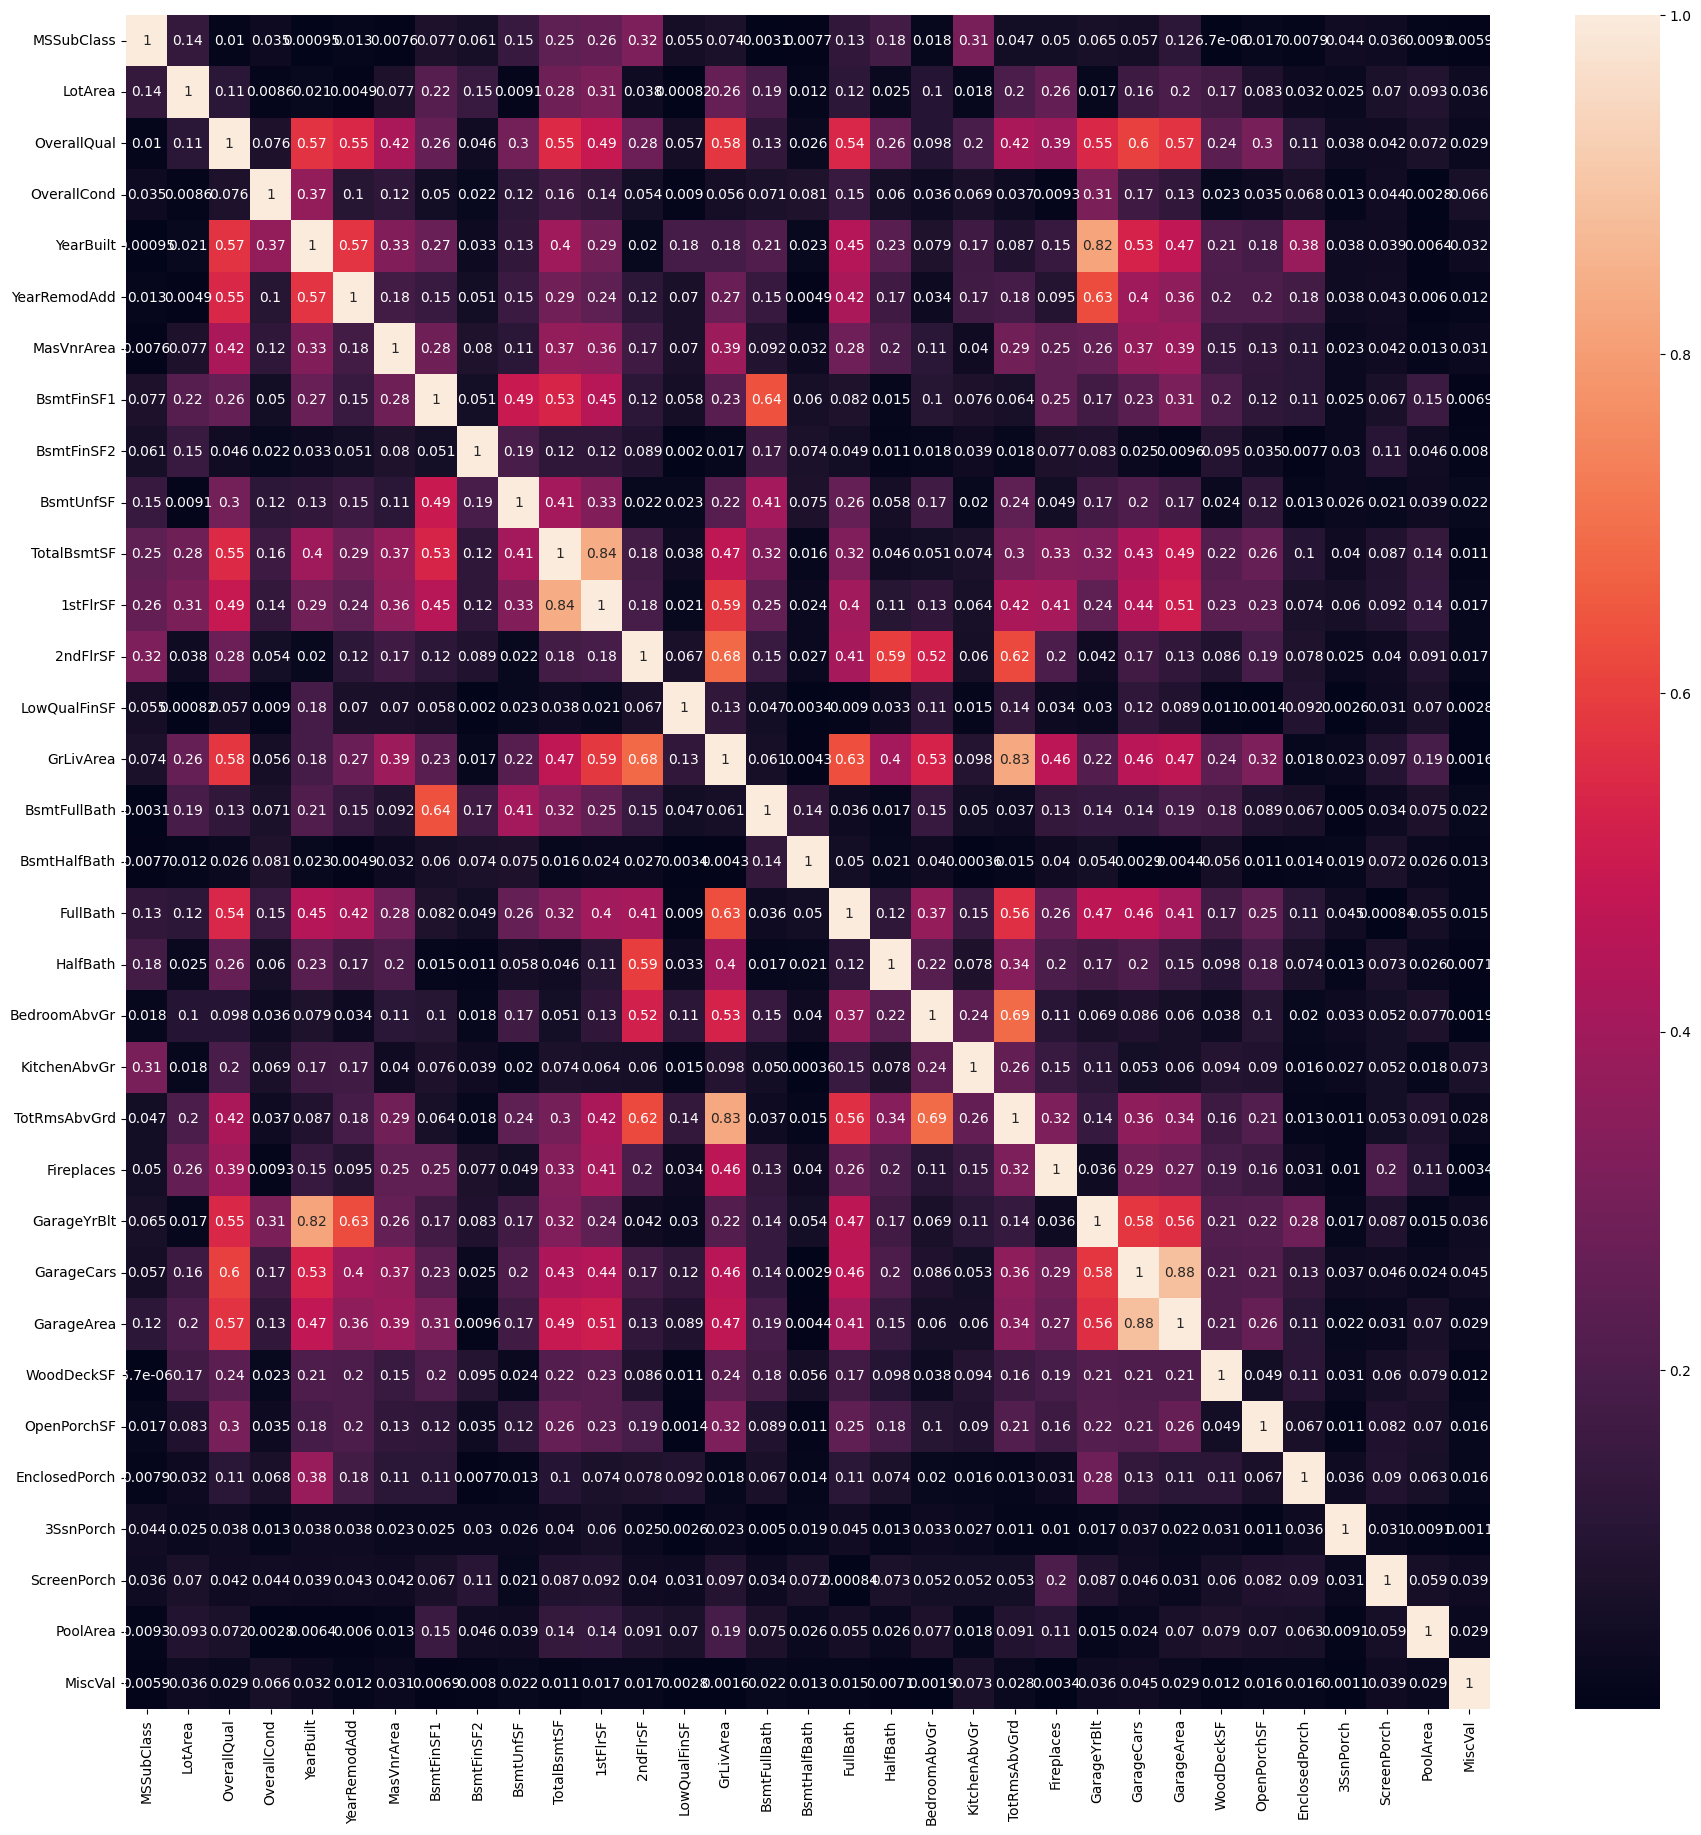

In [27]:
# Create the correlation matrix, using the absolute values.
# For our purpose, it doesn't matter whether the correlation is positive or negative.
corrMatrix = X_train.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(22,22))
sns.heatmap(corrMatrix, annot=True);

In [28]:
# Select the upper triangle of the correlation matrix.
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))

upper

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
MSSubClass,NaN,0.140527,0.010195,0.034672,0.000951,0.012973,0.007641,0.076540,0.061162,0.145592,...,0.064688,0.057495,0.120671,0.000007,0.017439,0.007933,0.044193,0.035758,0.009318,0.005926
LotArea,NaN,NaN,0.109849,0.008596,0.020954,0.004920,0.077488,0.224165,0.151042,0.009132,...,0.017471,0.163557,0.195331,0.174330,0.083060,0.031974,0.024868,0.070452,0.093495,0.036294
OverallQual,NaN,NaN,NaN,0.075525,0.573105,0.545806,0.419570,0.261590,0.045819,0.296410,...,0.546768,0.604725,0.571549,0.236756,0.302142,0.110442,0.038212,0.041904,0.072232,0.029436
OverallCond,NaN,NaN,NaN,NaN,0.369359,0.102497,0.123010,0.050076,0.021894,0.120111,...,0.314313,0.165641,0.131953,0.022753,0.034670,0.067677,0.012844,0.043522,0.002770,0.065616
YearBuilt,NaN,NaN,NaN,NaN,NaN,0.574465,0.327571,0.268097,0.032975,0.130764,...,0.817516,0.529871,0.474608,0.206932,0.179828,0.379291,0.037985,0.039151,0.006435,0.032050
YearRemodAdd,NaN,NaN,NaN,NaN,NaN,NaN,0.177020,0.151615,0.050691,0.154714,...,0.625647,0.396378,0.356242,0.202749,0.201625,0.178187,0.038480,0.043483,0.006024,0.011946
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.279630,0.080294,0.109692,...,0.258404,0.373659,0.385794,0.149679,0.129393,0.109717,0.023445,0.042041,0.013451,0.030787
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050855,0.492808,...,0.173066,0.228203,0.311111,0.199392,0.124736,0.111352,0.025097,0.066678,0.153372,0.006882
BsmtFinSF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194585,...,0.082827,0.024826,0.009587,0.095277,0.035216,0.007707,0.029867,0.105682,0.045675,0.007975
BsmtUnfSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.173677,0.203870,0.170809,0.024023,0.121427,0.013288,0.025593,0.021455,0.039220,0.021647


## K Best

In [29]:
tree_kbest = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_regression, k=10)),
    ('estimator', DecisionTreeRegressor())
])

neigh_kbest = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_regression, k=10)),
    ('estimator', KNeighborsRegressor(n_neighbors=1))
])

In [30]:
tree_kbest.fit(X_train, y_train)
neigh_kbest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('feature_selector',
                 SelectKBest(score_func=<function f_regression at 0x7f162c2bd7e0>)),
                ('estimator', KNeighborsRegressor(n_neighbors=1))])

In [31]:
tree_kbest_pred = tree_kbest.predict(X_test)
neigh_kbest_pred = neigh_kbest.predict(X_test)

In [32]:
performances.loc['KBest', 'performance_tree'] = mean_squared_log_error(y_true=y_test, y_pred=tree_kbest_pred)
performances.loc['KBest', 'performance_knn'] = mean_squared_log_error(y_true=y_test, y_pred=neigh_kbest_pred)
performances

,performance_tree,performance_knn
baseline,0.036514,0.051006
varThreshold,0.040308,0.051006
KBest,0.040148,0.03775


## Recursive Feature Elimination (RFE)

In [33]:
tree_rfe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', RFECV(DecisionTreeRegressor()))
])

In [34]:
tree_rfe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('feature_selector', RFECV(estimator=DecisionTreeRegressor()))])

In [35]:
tree_rfe_pred = tree_rfe.predict(X_test)

In [36]:
performances.loc['RFE', 'performance_tree'] = mean_squared_log_error(y_true=y_test, y_pred=tree_rfe_pred)
performances

,performance_tree,performance_knn
baseline,0.036514,0.051006
varThreshold,0.040308,0.051006
KBest,0.040148,0.03775
RFE,0.050949,NaN


## Select from Model

In [37]:
tree_smodel = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(DecisionTreeRegressor())),
    ('estimator', DecisionTreeRegressor())
])

knn_smodel = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(DecisionTreeRegressor())),
    ('estimator', KNeighborsRegressor(n_neighbors=1))
])

In [38]:
tree_smodel.fit(X_train, y_train)
knn_smodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'Gr...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive'],
      dtype='object'))])),
                ('feature_selector',
                 SelectFromModel(estimator=DecisionTreeRegressor())),
                ('estimator', KNeighborsRegressor(n_neighbors=1))])

In [39]:
tree_smodel_pred = tree_smodel.predict(X_test)
neigh_smodel_pred = knn_smodel.predict(X_test)

In [40]:
performances.loc['SModel', 'performance_tree'] = mean_squared_log_error(y_true=y_test, y_pred=tree_smodel_pred)
performances.loc['SModel', 'performance_knn'] = mean_squared_log_error(y_true=y_test, y_pred=neigh_smodel_pred)
performances

,performance_tree,performance_knn
baseline,0.036514,0.051006
varThreshold,0.040308,0.051006
KBest,0.040148,0.03775
RFE,0.050949,NaN
SModel,0.042339,0.044818


## Gradientboostregressor (GBR)

In [41]:
# creating the final pipeline
final_pipe_gb = make_pipeline(preprocessor,
                              StandardScaler(with_mean=False),
                              VarianceThreshold(),
                              SelectKBest(score_func=f_regression),
                              GradientBoostingRegressor(),
                              )

In [42]:
# deciding on the parameter to test in the gridsearch
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "constant"],
    "gradientboostingregressor__loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "gradientboostingregressor__criterion": ["friedman_mse", "squared_error"],
    "gradientboostingregressor__n_estimators": range(50, 150, 20),
    "selectkbest__k": range(5, 85, 5)
}

In [43]:
# creating a randomized search with pipeline and parameters and fit
gb_search = RandomizedSearchCV(final_pipe_gb,
                              param_grid,
                              cv=5,
                              n_iter = 10,
                              scoring='neg_mean_squared_log_error',
                              verbose=1)

gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '...
                   param_distributions={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                                 'median',
                                                                                                 'constant'],
                                        'gradientboostingregressor__criterion': ['friedman_mse',
                                                                                 'squared_error'],
                                        'gradientboostingregressor__loss': ['squared_error',
                                                                            'absolute_error',
                                                                            'huber',
                                                                            'quantile'],
                                        'gradientboostingregressor__n_estimators': range(50, 150, 20),
                                        'selectkbest__k': range(5, 85, 5)},
                   scoring='neg_mean_squared_log_error', verbose=1)

In [44]:
gb_search.best_score_

-0.02143054378021589

In [45]:
abs(gb_search.best_score_)**0.5

0.1463917476506647